In [3]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install
  #!pip install git+https://github.com/Effective-Quadratures/Effective-Quadratures.git@master # for specific branch

import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
from equadratures import *
from mpl_toolkits.mplot3d import axes3d
import types

if not IN_COLAB:
    %matplotlib notebook

Define the function and training data:

In [30]:
N = 500
n = 4 # degree of polynomial
dim = 2

def our_function(x):
    x0 = x[:,0]
    x1 = x[:,1]
    y = 0.3*x0**4 -1.6*x0**3 +0.6*x0**2 +2.4*x0 -0.3*x1**4 +1.6*x1**3 -2.4*x1 - 0.5
    return y

# Training points
x0 = (2*np.random.rand(N,1)-1)
x1 = (2*np.random.rand(N,1)-1)
x = np.hstack([x0,x1])
noise_var = 0.1
y = our_function(x) + np.random.randn(N,)*np.sqrt(noise_var)

Ntest = 20
x0_test = np.linspace(-1.,1., Ntest)
x1_test = np.linspace(-1.,1., Ntest)
x0_test,x1_test = np.meshgrid(x0_test,x1_test,indexing='ij')
x0_testv = np.reshape(x0_test, (Ntest**2, 1))
x1_testv = np.reshape(x1_test, (Ntest**2, 1))
xtest = np.hstack([x0_testv,x1_testv])
ytest = our_function(xtest).reshape(-1,1)

Define the get_polyvar() function (to bind to `Poly` later)

In [31]:
def get_polyvar(self,stack_of_points):
    w = self.get_coefficients()
    x = self.inputs
    y = self.outputs
    # Check that dimensions of x and stack_of_points match
    _, dimensions = self.basis.elements.shape
    if stack_of_points.ndim == 1:
        no_of_points = 1
    else:
        no_of_points, _ = stack_of_points.shape
    if stack_of_points.shape[1] != dimensions: raise ValueError('get_polyvar(): dimensions of training data and stack_of_points do not match') 

    xb     = self.get_poly(x)
    xtestb = self.get_poly(stack_of_points)
    ytest = self.get_polyfit(stack_of_points)
    # Empirical variance (RMS of poly approx)
    sigma2 = ((y - self.get_polyfit(x))**2).mean()
    # Get variance 
    xtestb = xtestb.T
    xb = xb.T
    var = np.diag(sigma2*np.dot(np.dot(xtestb,np.linalg.inv(np.dot(xb.T,xb))),xtestb.T))
    return var.reshape(-1,1)

Fit a polynomial with EQ, and calc poly approx and variance. 

In [32]:
# EQ
param = Parameter(distribution='Uniform', lower=np.min(x), upper=np.max(x), order=n)
myParameters = [param for i in range(dim)] # one-line for loop for parameters

myBasis = Basis('total-order')
poly = Poly(myParameters, myBasis, method='least-squares', sampling_args={'sample-points':x, 'sample-outputs':y} )
poly.set_model()

# bind the get_polyvar function as a method to poly
poly.get_polyvar = types.MethodType( get_polyvar, poly )
testvar = poly.get_polyvar(xtest)

## Do the plotting:
std = np.sqrt(testvar)#*1.96
lower = ytest-std
upper = ytest+std
ypoly = poly.get_polyfit(xtest)

Plot!

<IPython.core.display.Javascript object>


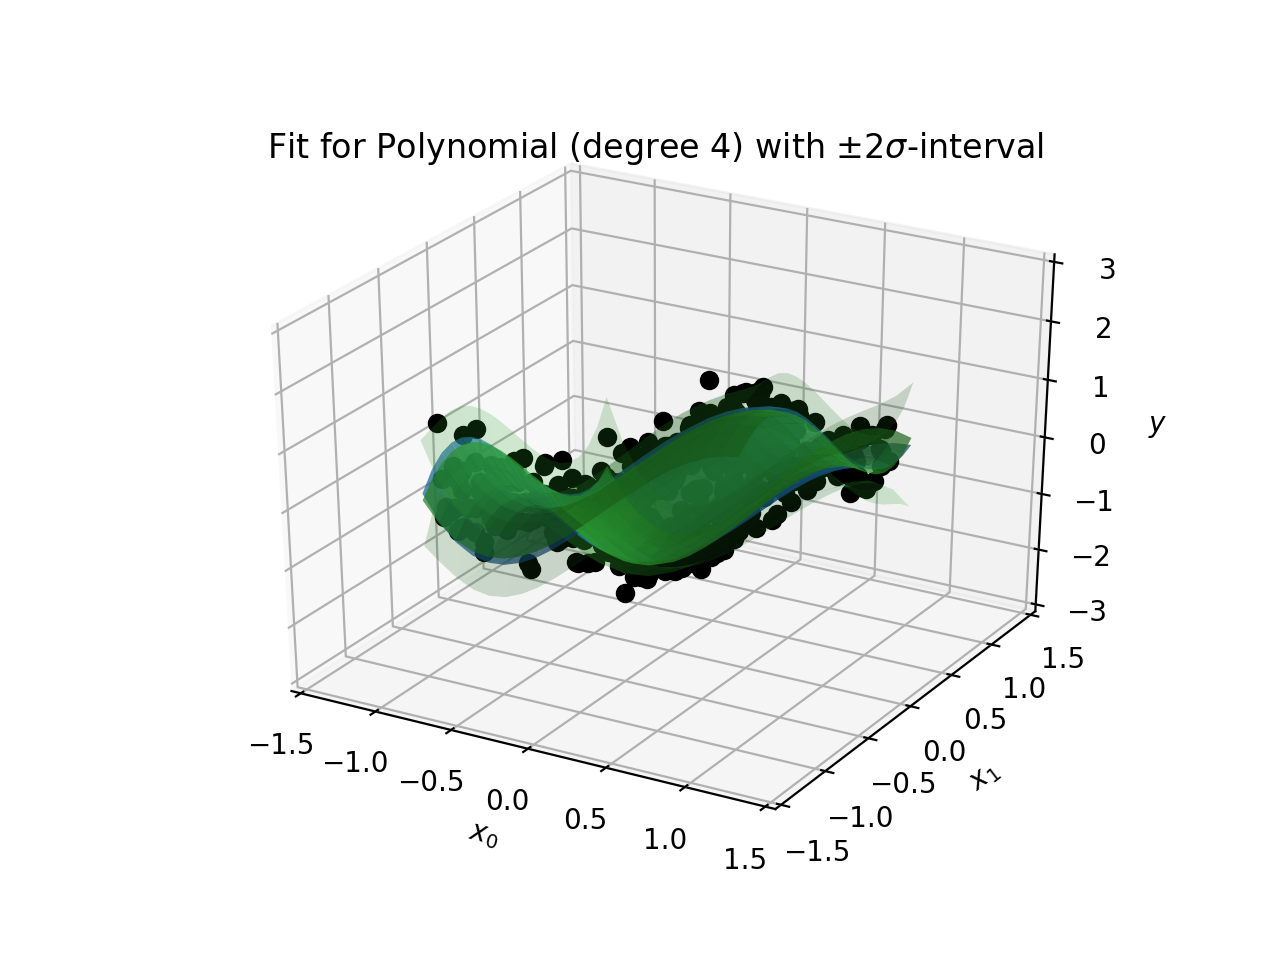

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Fit for Polynomial (degree {}) with $\pm2\sigma$-interval".format(n))

# Function and training points
ax.plot_surface(x0_test, x1_test,ytest.reshape([Ntest,Ntest]), rstride=1,cstride=1, color='C0', linewidth=0,label='Truth',alpha=0.7)
plt.plot(x[:,0],x[:,1],y,'ko',label='Training points')

# The poly approx and std
ax.plot_surface(xtest[:,0].reshape([Ntest,Ntest]), xtest[:,1].reshape([Ntest,Ntest]), ypoly.reshape([Ntest,Ntest]),rstride=1,cstride=1, color='C2', linewidth=0,label='EQ',alpha=0.7)
ax.plot_surface(xtest[:,0].reshape([Ntest,Ntest]), xtest[:,1].reshape([Ntest,Ntest]), lower.reshape([Ntest,Ntest]),rstride=1,cstride=1, color='C2', linewidth=0,label='_nolegend_',alpha=0.2)
ax.plot_surface(xtest[:,0].reshape([Ntest,Ntest]), xtest[:,1].reshape([Ntest,Ntest]), upper.reshape([Ntest,Ntest]),rstride=1,cstride=1, color='C2', linewidth=0,label='_nolegend_',alpha=0.2)

ax.axis('tight')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-3,3])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$y$')
plt.show()

Plot along the line $x_1=0$ to see whats going on!

<IPython.core.display.Javascript object>


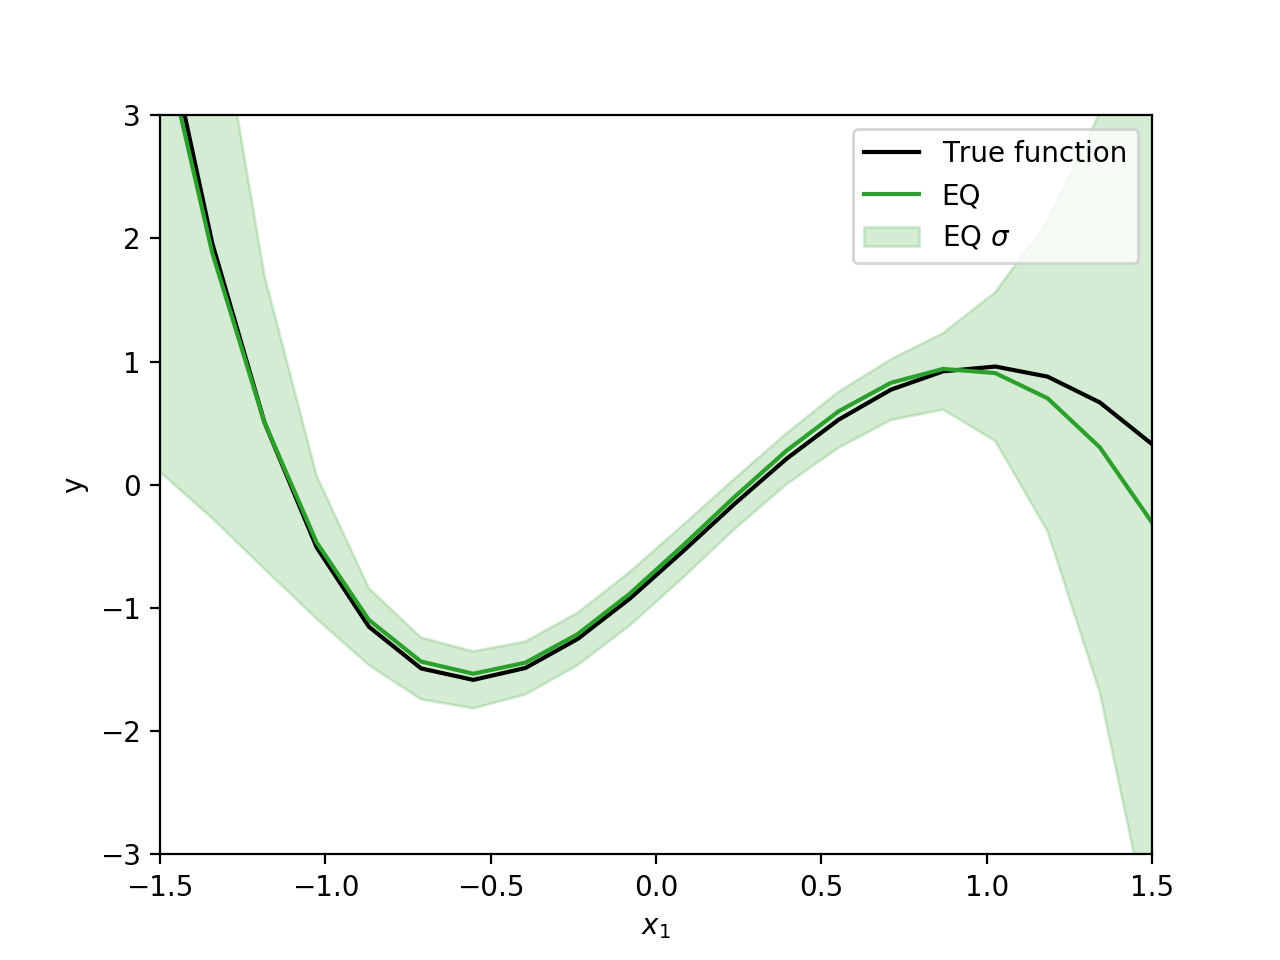

In [42]:
Ntest = 20
x0_test = np.linspace(-1.5,1.5, Ntest).reshape(-1,1)
x1_test = np.ones_like(x0_test).reshape(-1,1)*0.1
xtest = np.hstack([x0_test,x1_test])
ytest = our_function(xtest).reshape(-1,1)

fig, ax = plt.subplots()
ax.plot(x0_test,ytest,'-k',label='True function')
ax.plot(x0_test,poly.get_polyfit(xtest),'C2-',label='EQ')
std = np.sqrt(poly.get_polyvar(xtest))
plt.fill_between(x0_test.squeeze(),(ytest-std).squeeze(),(ytest+std).squeeze(),color='C2',alpha=0.2,label='EQ $\sigma$')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-3,3)
ax.set_xlabel('$x_1$')
ax.set_ylabel('y')
ax.legend()

plt.show()